In [1]:
# === Setup (Colab) ===
!pip -q install scikit-learn matplotlib seaborn pandas numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from google.colab import files
import io, textwrap, sys, warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
sns.set(context="notebook", style="whitegrid")


In [2]:
# === Upload customer_data.csv from your computer ===
print("Upload your customer_data.csv file…")
uploaded = files.upload()

# If the file name differs, adjust below:
df = pd.read_csv(io.BytesIO(uploaded['customer_data.csv']))

print("Shape:", df.shape)
display(df.head())


Upload your customer_data.csv file…


Saving customer_data.csv to customer_data.csv
Shape: (200, 4)


,Customer ID,Age,Annual Income,Spending Score
0,1,56,73053,58
1,2,69,36959,67
2,3,46,20530,46
3,4,32,109856,24
4,5,60,18748,32


In [3]:
print("\n--- Info ---")
df.info()

print("\n--- Missing values per column ---")
print(df.isna().sum())

print("\n--- Duplicate rows ---")
print(df.duplicated().sum())

print("\n--- Summary statistics ---")
display(df.describe(include='all').T)



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Customer ID     200 non-null    int64
 1   Age             200 non-null    int64
 2   Annual Income   200 non-null    int64
 3   Spending Score  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB

--- Missing values per column ---
Customer ID       0
Age               0
Annual Income     0
Spending Score    0
dtype: int64

--- Duplicate rows ---
0

--- Summary statistics ---


,count,mean,std,min,25%,50%,75%,max
Customer ID,200.0,100.500,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,43.425,14.941910,18.0,31.00,43.5,56.00,69.0
Annual Income,200.0,65777.545,30403.022894,15301.0,39804.00,64959.5,89960.50,119095.0
Spending Score,200.0,49.360,28.968193,1.0,24.00,49.5,69.25,99.0


In [4]:
# Drop full-row duplicates
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Removed {before - after} duplicate rows.")

# Simple missing handling strategy:
# - For numeric features: impute with median
# - For non-numeric: drop rows (rare here), or fill with mode (optional)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
non_numeric_cols = [c for c in df.columns if c not in numeric_cols]

for c in numeric_cols:
    if df[c].isna().sum() > 0:
        med = df[c].median()
        df[c] = df[c].fillna(med)

for c in non_numeric_cols:
    if df[c].isna().sum() > 0:
        mode_val = df[c].mode().iloc[0]
        df[c] = df[c].fillna(mode_val)

print("\nMissing after cleaning:")
print(df.isna().sum())


Removed 0 duplicate rows.

Missing after cleaning:
Customer ID       0
Age               0
Annual Income     0
Spending Score    0
dtype: int64


In [5]:
# Keep original copy for later joins/exports
df_orig = df.copy()

# Choose features for clustering:
feature_cols = ['Age', 'Annual Income', 'Spending Score']
for col in feature_cols:
    if col not in df.columns:
        raise ValueError(f"Missing expected column: {col}")

X = df[feature_cols].copy()

# Choose one scaler: StandardScaler or MinMaxScaler
use_minmax = False  # set True if you prefer 0-1 range

scaler = MinMaxScaler() if use_minmax else StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)


Scaled shape: (200, 3)


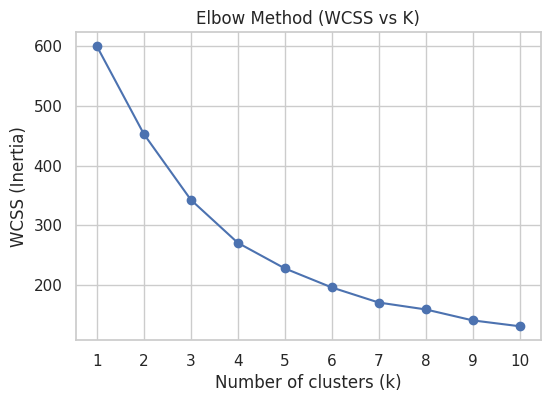


Silhouette scores (higher is better):
k=2: 0.2367
k=3: 0.2580
k=4: 0.2806
k=5: 0.2723
k=6: 0.2820
k=7: 0.2854
k=8: 0.2604
k=9: 0.2773
k=10: 0.2837

Auto-selected BEST_K by silhouette: 7


In [6]:
# Elbow: compute WCSS for k in 1..10 (or 12)
k_range = range(1, 11)
wcss = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(k_range), wcss, marker='o')
plt.title("Elbow Method (WCSS vs K)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(list(k_range))
plt.show()

# Silhouette: only valid for k >= 2
sil_scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil

print("\nSilhouette scores (higher is better):")
for k, s in sil_scores.items():
    print(f"k={k}: {s:.4f}")

# Pick the best k by silhouette (you can override manually if elbow suggests otherwise)
best_k_sil = max(sil_scores, key=sil_scores.get)
print(f"\nAuto-selected BEST_K by silhouette: {best_k_sil}")
BEST_K = best_k_sil


In [7]:
kmeans = KMeans(n_clusters=BEST_K, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

df_clustered = df_orig.copy()
df_clustered['Cluster'] = clusters

print("Cluster counts:")
display(df_clustered['Cluster'].value_counts().sort_index())

display(df_clustered.head())


Cluster counts:


,count
Cluster,
0,31
1,32
2,30
3,29
4,29
5,13
6,36


,Customer ID,Age,Annual Income,Spending Score,Cluster
0,1,56,73053,58,1
1,2,69,36959,67,4
2,3,46,20530,46,4
3,4,32,109856,24,0
4,5,60,18748,32,4


In [8]:
out_csv = "customer_data_clustered.csv"
df_clustered.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")
files.download(out_csv)


Saved: customer_data_clustered.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

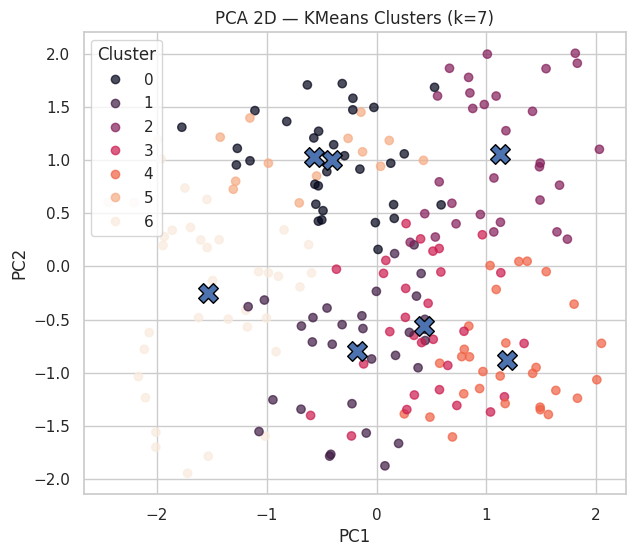

In [9]:
# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Centroids in PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, alpha=0.7)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], s=200, marker='X', edgecolor='black')
plt.title(f"PCA 2D — KMeans Clusters (k={BEST_K})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


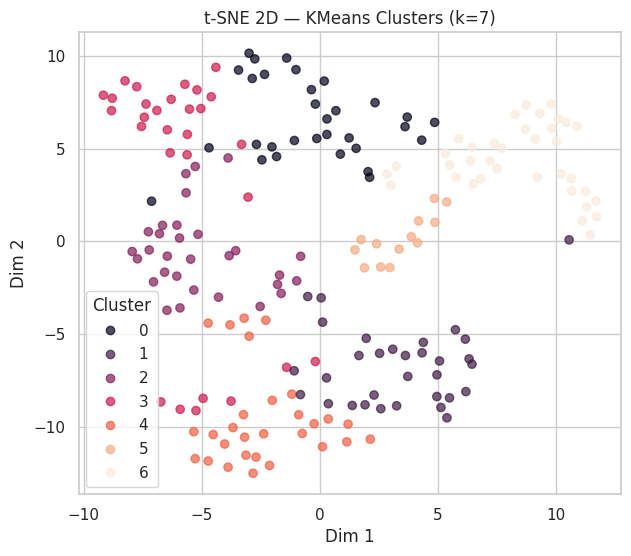

In [10]:
# t-SNE is stochastic; for speed use perplexity ~ 30 for mid-sized data
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='pca', n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, alpha=0.7)
plt.title(f"t-SNE 2D — KMeans Clusters (k={BEST_K})")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


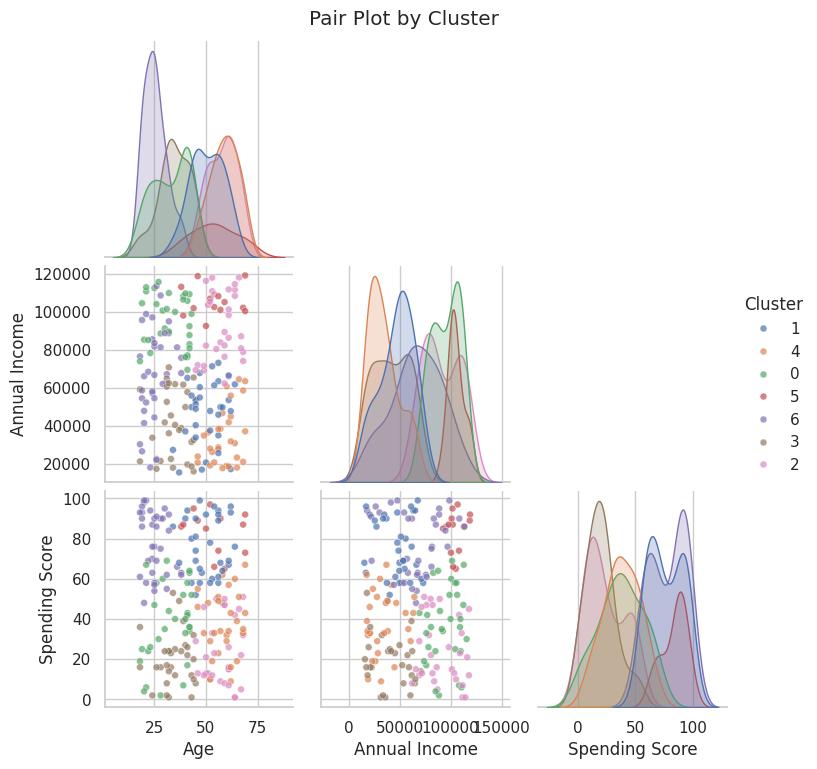

,Age,Annual Income,Spending Score
Cluster,,,
0,32.709677,94976.612903,37.322581
1,50.562500,46971.343750,76.187500
2,57.766667,91251.833333,23.800000
3,34.551724,41732.310345,19.827586
4,58.827586,34256.482759,38.172414
5,53.923077,105327.384615,83.538462
6,25.305556,66601.805556,77.638889


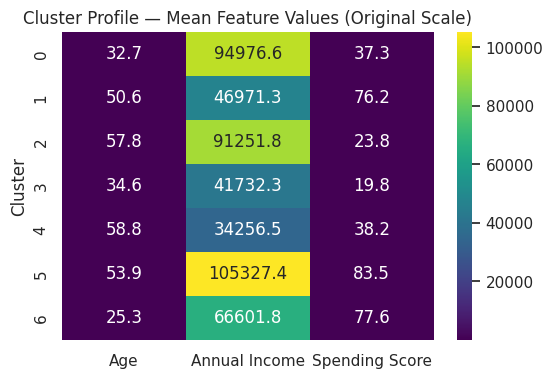

In [11]:
# Pairplot (can be slow for large data)
tmp = df_clustered[feature_cols + ['Cluster']].copy()
tmp['Cluster'] = tmp['Cluster'].astype(str)  # seaborn likes str hue
sns.pairplot(tmp, hue='Cluster', corner=True, plot_kws=dict(alpha=0.7, s=25))
plt.suptitle("Pair Plot by Cluster", y=1.02)
plt.show()

# Cluster-wise feature means (original scale)
cluster_profile = df_clustered.groupby('Cluster')[feature_cols].mean().sort_index()
display(cluster_profile)

plt.figure(figsize=(6,4))
sns.heatmap(cluster_profile, annot=True, fmt=".1f", cmap="viridis")
plt.title("Cluster Profile — Mean Feature Values (Original Scale)")
plt.show()


In [12]:
# Inverse-transform centroids to original scales for easy reading
centroids_original = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=feature_cols
)
centroids_original['Cluster'] = range(BEST_K)
centroids_original = centroids_original.set_index('Cluster').sort_index()

print("Centroids (Original Scale):")
display(centroids_original.round(2))


Centroids (Original Scale):


,Age,Annual Income,Spending Score
Cluster,,,
0,32.71,94976.61,37.32
1,50.56,46971.34,76.19
2,57.77,91251.83,23.80
3,34.55,41732.31,19.83
4,58.83,34256.48,38.17
5,53.92,105327.38,83.54
6,25.31,66601.81,77.64


In [13]:
# Rank clusters by income/spending to derive segment names
cent = centroids_original.copy()
cent['IncomeRank'] = cent['Annual Income'].rank(method='dense')
cent['SpendRank']  = cent['Spending Score'].rank(method='dense')

def name_segment(row):
    inc = "High Income" if row['IncomeRank'] >= cent['IncomeRank'].median() else "Low/Med Income"
    spend = "High Spending" if row['SpendRank'] >= cent['SpendRank'].median() else "Low/Med Spending"
    # refine with age
    age_tag = "Young" if row['Age'] < cent['Age'].median() else "Mature"
    return f"{inc} – {spend} ({age_tag})"

segment_names = cent.apply(name_segment, axis=1)
segment_map = segment_names.to_dict()

# Attach segment names to each customer
df_clustered['Segment'] = df_clustered['Cluster'].map(segment_map)

# High-level insights
summary = df_clustered.groupby(['Cluster','Segment']).agg(
    Customers=('Customer ID', 'count') if 'Customer ID' in df_clustered.columns else ('Segment','count'),
    Avg_Age=('Age','mean'),
    Avg_Income=('Annual Income','mean'),
    Avg_Spending=('Spending Score','mean')
).round(2)

print("\n=== Segment Summary ===")
display(summary)

# Recommendations based on segments
actions = []
for c, row in cent.iterrows():
    seg = segment_map[c]
    recs = []

    # Income-based
    if row['Annual Income'] >= cent['Annual Income'].median():
        recs.append("Upsell premium products; bundle high-value offers.")
    else:
        recs.append("Value-for-money bundles; discounts to increase basket size.")

    # Spending-based
    if row['Spending Score'] >= cent['Spending Score'].median():
        recs.append("Launch loyalty/early-access perks; VIP communications.")
    else:
        recs.append("Engage with targeted promos and onboarding nudges.")

    # Age nuance
    if row['Age'] < cent['Age'].median():
        recs.append("Use social-first, mobile offers; gamified rewards.")
    else:
        recs.append("Highlight reliability, support, and convenience.")

    actions.append({
        "Cluster": c,
        "Segment": seg,
        "Key Traits": f"Age≈{row['Age']:.0f}, Income≈{row['Annual Income']:.0f}, SpendScore≈{row['Spending Score']:.0f}",
        "Recommendations": " | ".join(recs)
    })

rec_df = pd.DataFrame(actions).sort_values("Cluster")
display(rec_df)

# Save outputs
df_clustered.to_csv("customer_data_clustered_with_segments.csv", index=False)
summary.to_csv("cluster_segment_summary.csv")
rec_df.to_csv("cluster_recommendations.csv", index=False)

print("\nSaved: customer_data_clustered_with_segments.csv, cluster_segment_summary.csv, cluster_recommendations.csv")
files.download("customer_data_clustered_with_segments.csv")
files.download("cluster_segment_summary.csv")
files.download("cluster_recommendations.csv")



=== Segment Summary ===


,,Customers,Avg_Age,Avg_Income,Avg_Spending
Cluster,Segment,,,,
0,High Income – Low/Med Spending (Young),31,32.71,94976.61,37.32
1,Low/Med Income – High Spending (Mature),32,50.56,46971.34,76.19
2,High Income – Low/Med Spending (Mature),30,57.77,91251.83,23.80
3,Low/Med Income – Low/Med Spending (Young),29,34.55,41732.31,19.83
4,Low/Med Income – High Spending (Mature),29,58.83,34256.48,38.17
5,High Income – High Spending (Mature),13,53.92,105327.38,83.54
6,High Income – High Spending (Young),36,25.31,66601.81,77.64


,Cluster,Segment,Key Traits,Recommendations
0,0,High Income – Low/Med Spending (Young),"Age≈33, Income≈94977, SpendScore≈37",Upsell premium products; bundle high-value off...
1,1,Low/Med Income – High Spending (Mature),"Age≈51, Income≈46971, SpendScore≈76",Value-for-money bundles; discounts to increase...
2,2,High Income – Low/Med Spending (Mature),"Age≈58, Income≈91252, SpendScore≈24",Upsell premium products; bundle high-value off...
3,3,Low/Med Income – Low/Med Spending (Young),"Age≈35, Income≈41732, SpendScore≈20",Value-for-money bundles; discounts to increase...
4,4,Low/Med Income – High Spending (Mature),"Age≈59, Income≈34256, SpendScore≈38",Value-for-money bundles; discounts to increase...
5,5,High Income – High Spending (Mature),"Age≈54, Income≈105327, SpendScore≈84",Upsell premium products; bundle high-value off...
6,6,High Income – High Spending (Young),"Age≈25, Income≈66602, SpendScore≈78",Upsell premium products; bundle high-value off...



Saved: customer_data_clustered_with_segments.csv, cluster_segment_summary.csv, cluster_recommendations.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  Overall Summary

In this project, we carried out **Customer Segmentation using K-Means Clustering** on the dataset containing **Age, Annual Income, and Spending Score**.  

###  Data Preparation
- The dataset was inspected for **missing values, duplicates, and data types**.  
- After cleaning, the features were **standardized** to bring them to the same scale, ensuring clustering accuracy.  

###  Clustering Process
- The **Elbow Method (WCSS)** and **Silhouette Scores** were used to determine the optimal number of clusters.  
- **K-Means** was applied, and each customer was assigned a **Cluster label**.  

###  Visualizations
- **Elbow Plot:** Clearly showed the “elbow point” for selecting the best number of clusters.  
- **PCA Scatter Plot:** Reduced dimensions to 2D and displayed clusters in different colors along with centroids.  
- **t-SNE Plot:** Gave another perspective of how customers group together non-linearly.  
- **Pair Plot:** Showed relationships between Age, Income, and Spending Score within clusters.  
- **Heatmap of Centroids:** Displayed average feature values per cluster, making interpretation easier.  

###  Cluster Profiles
- Each cluster was summarized with **average age, income, and spending score**, helping to identify meaningful groups such as:  
  - **High Income – High Spending**  
  - **High Income – Low Spending**  
  - **Low Income – High Spending**  
  - **Young vs Mature segments**  

###  Business Insights & Recommendations
- Focus premium marketing strategies on **High Income – High Spending** customers.  
- Offer **loyalty programs** to retain high-spending groups.  
- Provide **discounts and value bundles** to attract low-income but high-spending clusters.  
- Engage **young customers** through mobile-first and social campaigns.  
- Build **trust and convenience services** for mature customers.  

---

###  Final Note
This clustering analysis produced **clean, well-structured data**, insightful **visualizations**, and **actionable strategies**.  
It enables businesses to:  
- **Understand customer behavior more clearly**  
- **Target the right groups effectively**  
- **Allocate resources wisely**  
- Ultimately drive **better marketing outcomes and customer satisfaction**.  
